In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import pyspark.sql.functions as func
from pyspark.sql.functions import length
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import findspark
import string
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import sql
from pyspark.streaming import StreamingContext

spark = SparkSession.builder.appName("hackaton").getOrCreate()

sc = spark.sparkContext

In [4]:
df = spark.read.option('header', True).csv('/content/drive/MyDrive/HackAThon2021/Data/Charity Navigator Scores Expenses Dataset/CLEAN_charity_data.csv') #reading csv into spark context 

In [ ]:
df.show(3) #show the top 3 row of the dataframe in spark 

+------+--------------------+--------------------+----------+---------+-------------------+--------+-------------------+------------------+------+------------------+-----------+--------------------+--------------------+--------------------+---------+-----+-----+--------------------+-----+------------------+------------------+-----------+
|ascore|            category|         description|       ein|  tot_exp|        admin_exp_p|fund_eff|         fund_exp_p|     program_exp_p|fscore|            leader|leader_comp|       leader_comp_p|               motto|                name|  tot_rev|score|state|         subcategory| size|       program_exp|          fund_exp|  admin_exp|
+------+--------------------+--------------------+----------+---------+-------------------+--------+-------------------+------------------+------+------------------+-----------+--------------------+--------------------+--------------------+---------+-----+-----+--------------------+-----+------------------+------------

In [ ]:
print('Num of rows in dataset: ' + str(df.count())) #output the total number of rows in the dataframe 

Num of rows in dataset: 8710


In [ ]:
state = df.filter(df.state == 'MO') #looks at charity only specific to a location 
state.show(3)
print('Total number of charities in [given state]: ' + str(state.count())) #outputs the number of rows for a given state 
print('\nAll categories in [given state]: ')
state.select('category').distinct().show() #only output distinct rows 

+------+--------------+--------------------+----------+----------+-----------+--------+--------------------+------------------+------+--------------------+-----------+-------------+--------------------+--------------------+----------+-----+-----+--------------------+-----+------------------+-----------------+----------+
|ascore|      category|         description|       ein|   tot_exp|admin_exp_p|fund_eff|          fund_exp_p|     program_exp_p|fscore|              leader|leader_comp|leader_comp_p|               motto|                name|   tot_rev|score|state|         subcategory| size|       program_exp|         fund_exp| admin_exp|
+------+--------------+--------------------+----------+----------+-----------+--------+--------------------+------------------+------+--------------------+-----------+-------------+--------------------+--------------------+----------+-----+-----+--------------------+-----+------------------+-----------------+----------+
| 100.0|Human Services|Ozarks Food

In [6]:
df.groupBy('state').agg(func.count('state').alias('total')).show(20) #output the state of each charity, notice that there will be inaccurate data

+--------------------+-----+
|               state|total|
+--------------------+-----+
|              0.0325|    1|
|               65.32|    1|
|  David L. Kutchback|    1|
|           1240262.0|    1|
| 0.06860000000000001|    1|
|              0.0359|    1|
|Animal Rights, We...|    1|
|               0.147|    1|
|                0.07|    1|
|          31205313.0|    1|
|               92.14|    1|
|            237474.0|    1|
|                86.1|    1|
|                  AZ|  115|
|                  SC|   74|
|Saving the lives ...|    1|
|Diseases, Disorde...|    1|
|              0.0095|    1|
|           2544826.0|    1|
|Community Foundat...|    1|
+--------------------+-----+
only showing top 20 rows



In [100]:
result = df.groupBy('state').agg(func.count('state').alias('total')).sort(func.col('total').desc()).filter(length(df.state) == 2) #filter through the dataframe group each state and calculate the total num of rows for that state 
result.write.option("header", "true").csv("/content/drive/MyDrive/HackAThon2021/Data/states_and_numbers") #export this dataset that includes states and the total number of rows for each state

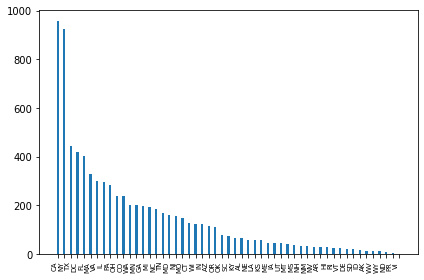

In [96]:
#using cleaned dataframe and the filtered dataframe that only includes the state and total rows for each state, plot a bar graph
numCharity = result.select('total').collect() 
state = result.select('state').collect()

numCharity = [int(row.total) for row in numCharity]
state = [row.state for row in state]

x = np.arange((len(state)))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x, numCharity, width, label = 'states')
ax.set_xticks(x)
ax.set_xticklabels(state)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')
plt.tight_layout()

In [7]:
df_clean = df.filter(length(df.state) == 2) #filter data to only include state characters == 2 
#output difference between filtered dataframe and original dataframe to see whether there is a difference in sizes 
print('Dataset with inaccurate data: ' + str(df.count())) 
print('Dataset with inaccurate data removed: ' + str(df_clean.count()))
#output the cleaned dataframe to a csv 
df_clean.write.option('header', 'true').csv('/content/drive/MyDrive/HackAThon2021/Data/CharityNav_Cleaned')

Dataset with inaccurate data: 8710
Dataset with inaccurate data removed: 8033


In [19]:
df_clean.groupBy(df_clean['state']).agg(func.avg('score').alias('average score')).sort(func.col('average score').desc()).show() #outputs the average scores for each state 

+-----+-----------------+
|state|    average score|
+-----+-----------------+
|   VI|             89.5|
|   VT|            89.33|
|   WY|          89.1775|
|   NM|        88.531875|
|   OR|88.41159292035394|
|   FL|88.07299251870324|
|   ID|87.94999999999999|
|   MO|87.90425675675677|
|   NE|87.88000000000001|
|   IA|87.84499999999998|
|   SC|87.82324324324327|
|   MN|87.79915422885568|
|   WI|87.79535999999999|
|   DE| 87.7395652173913|
|   TX| 87.6620898876404|
|   NC|87.53896739130428|
|   ND|87.47571428571429|
|   KY|87.38880597014926|
|   PA|87.35946808510639|
|   CO|87.31818565400846|
+-----+-----------------+
only showing top 20 rows



In [18]:
df_keyword_search = df_clean.filter(df_clean['motto'].rlike('.*(save){1}.*')) #outputs the state that has a motto which includes the word 'save'
print(df_keyword_search.count())
df_keyword_search.show(5)

21
+------+--------------------+--------------------+----------+----------+--------------------+--------+----------+------------------+------+--------------+-----------+-------------+--------------------+--------------------+-----------+-----+-----+--------------------+-----+-----------------+-----------+------------------+
|ascore|            category|         description|       ein|   tot_exp|         admin_exp_p|fund_eff|fund_exp_p|     program_exp_p|fscore|        leader|leader_comp|leader_comp_p|               motto|                name|    tot_rev|score|state|         subcategory| size|      program_exp|   fund_exp|         admin_exp|
+------+--------------------+--------------------+----------+----------+--------------------+--------+----------+------------------+------+--------------+-----------+-------------+--------------------+--------------------+-----------+-----+-----+--------------------+-----+-----------------+-----------+------------------+
|  70.0|      Human Services